In [133]:
#imports


from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/bstc/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bstc/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.I

In [134]:
# Import the data
# Data shape 5 dim vector []

### Hyperparameters

In [135]:
batch_size = 1000   # num of training examples to train on in a batch
limit_timesteps = 5 # sequence length
num_hidden_layers = 51
input_size = 2

future = 2

In [136]:
# Sequence model

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(input_size, num_hidden_layers)
        self.lstm2 = nn.LSTMCell(num_hidden_layers, num_hidden_layers)
        self.linear = nn.Linear(num_hidden_layers, input_size)

    def forward(self, input, future = 0):
        outputs = []
        
        h_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        
        # run 19 times
        # input_t.size = 5 x 5
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            input_t = input_t.squeeze(1)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            if (future == 0):
                outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        print(outputs.size())
        return outputs

In [137]:
# # set random seed to 0
# np.random.seed(0)
# torch.manual_seed(0)

# load data and make training set
data = pd.read_csv('cleaned/states_2017-08-28-00.csv')
# print(data['NMAC_id'][5])

# data_nparr = data.as_matrix()
# print(data_nparr[0])


# # drop unneeded columns to form matrix to be trained on
# data_matr = data.drop(['NMAC_id', 'alert_1', 'alert_2', 'onground_1', 'onground_2'], axis=1).as_matrix().astype('float')
# # print(data_m)

# restructure data
all_planes = []

count = 0
unique_icao = data.icao24.unique()
for i, name in enumerate(unique_icao):
    if count % 100 == 0: print(count)
    # only get batch size for now
    if count >= batch_size:
        break
    
    # get rows where icao == name (boolean vector)
    selector = data['icao24'] == name
    one_plane_df = data[selector]
    
#     for index, row in one_plane_df.iterrows():
        
    one_plane_df = one_plane_df.drop(['icao24','time','lat','lon', 'baroaltitude', 'heading', 'velocity'], axis=1)
    one_plane_arr = one_plane_df.as_matrix()
    one_plane_arr = one_plane_arr[0:limit_timesteps]
    
    all_planes.append(one_plane_arr)
    
    count += 1

batch = np.asarray(all_planes) # convert to np matrix

0
100
200
300
400
500
600
700
800
900
1000


In [138]:
input = Variable(torch.from_numpy(batch[100:,:-1,:]), requires_grad=False)
target = Variable(torch.from_numpy(batch[100:,1:,:]), requires_grad=False)
test_input = Variable(torch.from_numpy(batch[:100,:-future,:]), requires_grad=False)
test_target = Variable(torch.from_numpy(batch[:100,-future:,:]), requires_grad=False)
# data = torch.load('traindata.pt')
# input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
# target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
# test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
# test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)
print(batch[0])
print(batch.shape)
# print(batch)

[[-4.22551607  1.95437622]
 [-4.22551607  1.95437622]
 [-4.22551607  1.95437622]
 [-4.22551607  1.95437622]
 [-4.22551607  1.95437622]]
(1000, 5, 2)


In [139]:


# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# begin to train
for i in range(10):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    
    # begin to predict
    pred = seq(test_input, future = future)
#     pred1 = seq(test_input[:1, :, :])
    loss = criterion(pred, test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
print(pred)

#     # draw the result
#     plt.figure(figsize=(30,10))
#     plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
#     plt.xlabel('x', fontsize=20)
#     plt.ylabel('y', fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     def draw(yi, color):
#         plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
#         plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
#     draw(y[0], 'r')
#     draw(y[1], 'g')
#     draw(y[2], 'b')
#     plt.savefig('predict%d.pdf'%i)
#     plt.close()


STEP:  0
torch.Size([900, 4, 2])
loss: 0.00617855181705
torch.Size([900, 4, 2])
loss: 0.00328481985574
torch.Size([900, 4, 2])
loss: 0.00327415542869
torch.Size([900, 4, 2])
loss: 0.00327358366511
torch.Size([900, 4, 2])
loss: 0.00327338680591
torch.Size([900, 4, 2])
loss: 0.00327289644508
torch.Size([900, 4, 2])
loss: 0.00327177543053
torch.Size([900, 4, 2])
loss: 0.00326919552328
torch.Size([900, 4, 2])
loss: 0.00326337037626
torch.Size([900, 4, 2])
loss: 0.00325067824626
torch.Size([900, 4, 2])
loss: 0.00322477126141
torch.Size([900, 4, 2])
loss: 0.00317587332204
torch.Size([900, 4, 2])
loss: 0.00309123853648
torch.Size([900, 4, 2])
loss: 0.0030620030669
torch.Size([900, 4, 2])
loss: 0.0030348511867
torch.Size([900, 4, 2])
loss: 0.00292311191921
torch.Size([900, 4, 2])
loss: 0.00273768177934
torch.Size([900, 4, 2])
loss: 0.00238386902436
torch.Size([900, 4, 2])
loss: 0.00263294265484
torch.Size([900, 4, 2])
loss: 0.00190434932754
torch.Size([100, 2, 2])
test loss: 0.0742751916199
ST

torch.Size([900, 4, 2])
loss: 0.000151830940818
torch.Size([900, 4, 2])
loss: 0.000150674371819
torch.Size([900, 4, 2])
loss: 0.000149484269258
torch.Size([900, 4, 2])
loss: 0.000147672475229
torch.Size([900, 4, 2])
loss: 0.000146118059395
torch.Size([900, 4, 2])
loss: 0.000145203154749
torch.Size([900, 4, 2])
loss: 0.000143995759805
torch.Size([900, 4, 2])
loss: 0.000143273799426
torch.Size([900, 4, 2])
loss: 0.000142841524108
torch.Size([900, 4, 2])
loss: 0.000142540300387
torch.Size([900, 4, 2])
loss: 0.000142364108361
torch.Size([900, 4, 2])
loss: 0.000142249793514
torch.Size([900, 4, 2])
loss: 0.000142119516964
torch.Size([900, 4, 2])
loss: 0.000141941389695
torch.Size([900, 4, 2])
loss: 0.000141702616422
torch.Size([900, 4, 2])
loss: 0.000141508087178
torch.Size([900, 4, 2])
loss: 0.000141261062351
torch.Size([900, 4, 2])
loss: 0.000141143672688
torch.Size([100, 2, 2])
test loss: 0.0362075953343
STEP:  9
torch.Size([900, 4, 2])
loss: 0.000141002283455
torch.Size([900, 4, 2])
loss

torch.Size([100, 2, 2])
Variable containing:
-4.2255  1.9544
-4.2255  1.9544
-4.2255  1.9544
[torch.DoubleTensor of size 3x2]

[[-1.95141942  1.17546969]
 [-1.76770122  1.22785098]]


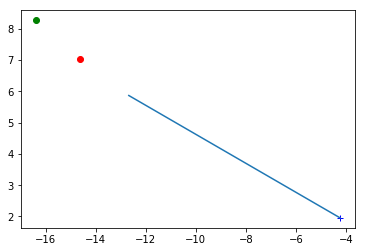

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -2.4512  0.5074
 -2.4759  0.5125
[torch.DoubleTensor of size 3x2]

[[-0.02336793  0.0055257 ]
 [-0.02737782  0.00875815]]


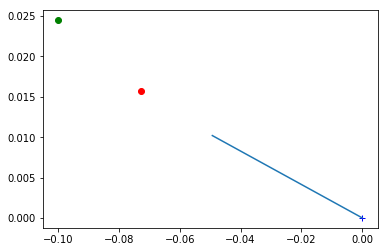

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


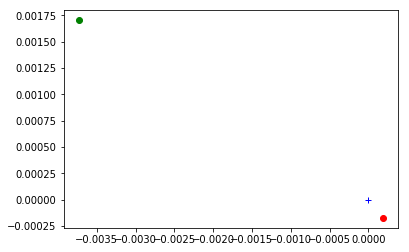

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -2.2100 -1.2197
 -2.2292 -1.2290
[torch.DoubleTensor of size 3x2]

[[-0.02079129 -0.01239121]
 [-0.02440853 -0.00936067]]


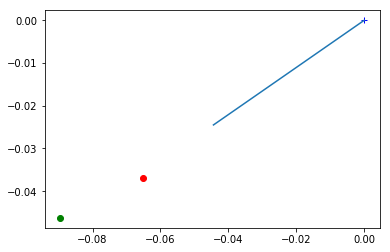

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  2.0891  0.4447
  2.4260  0.5189
[torch.DoubleTensor of size 3x2]

[[ 0.02268285  0.00456436]
 [ 0.01820632  0.00555501]]


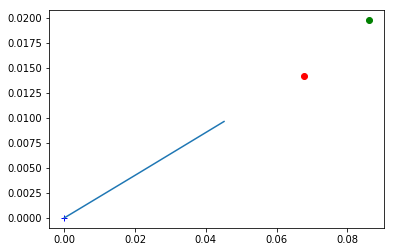

Variable containing:
1.00000e-02 *
  0.4957 -3.5202
  0.4957 -3.5202
  0.4957 -3.5202
[torch.DoubleTensor of size 3x2]

[[ 0.00595749 -0.03635051]
 [ 0.00311494 -0.03469313]]


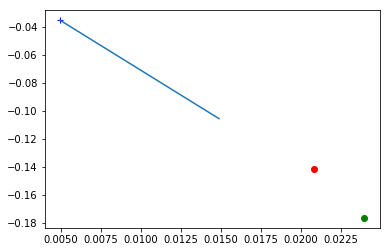

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  1.2681 -1.7578
  1.4569 -2.0035
[torch.DoubleTensor of size 3x2]

[[ 0.014248   -0.02070547]
 [ 0.01045882 -0.01937882]]


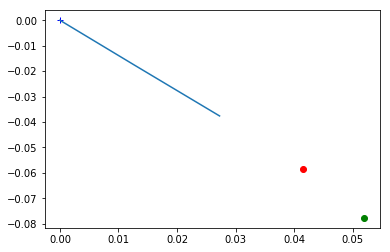

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  1.0879  0.0527
  1.1854  0.0838
[torch.DoubleTensor of size 3x2]

[[ 0.01130181  0.00041643]
 [ 0.00705971  0.0019328 ]]


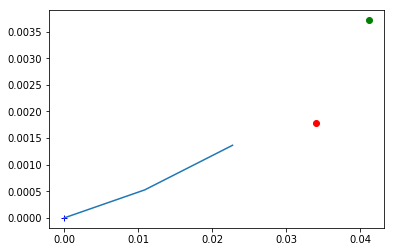

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  0.5083 -1.9909
  0.5081 -1.9971
[torch.DoubleTensor of size 3x2]

[[ 0.00534327 -0.02073093]
 [ 0.00168157 -0.01899564]]


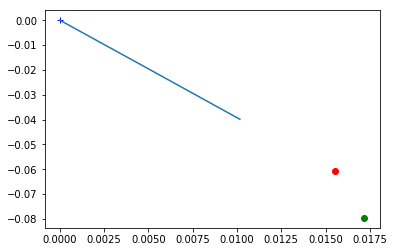

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  2.6337 -1.4236
  2.2300 -1.2010
[torch.DoubleTensor of size 3x2]

[[ 0.0220278  -0.0131973 ]
 [ 0.01809139 -0.012326  ]]


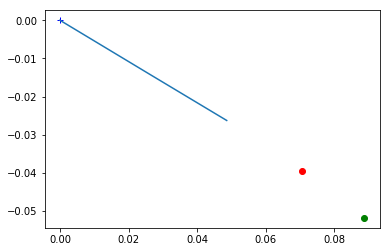

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  2.0864  0.1014
  2.0031  0.1007
[torch.DoubleTensor of size 3x2]

[[ 0.0193206   0.00043391]
 [ 0.01501088  0.00152077]]


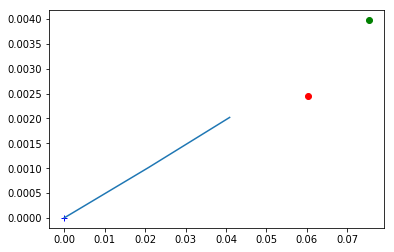

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -1.1433  1.8202
 -1.0922  1.7457
[torch.DoubleTensor of size 3x2]

[[-0.01049954  0.01804133]
 [-0.01496027  0.02070163]]


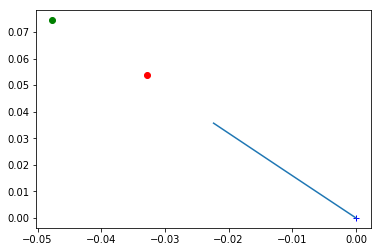

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  0.5211 -2.0343
  0.2394 -1.1219
[torch.DoubleTensor of size 3x2]

[[ 0.00260507 -0.01273081]
 [-0.00108735 -0.01087681]]


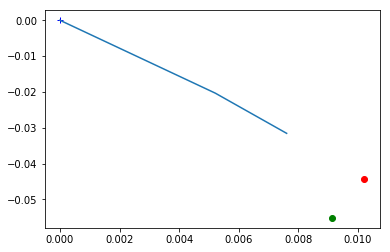

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -0.5424  1.9785
 -0.5493  1.9878
[torch.DoubleTensor of size 3x2]

[[-0.00535451  0.02032014]
 [-0.00991084  0.02272299]]


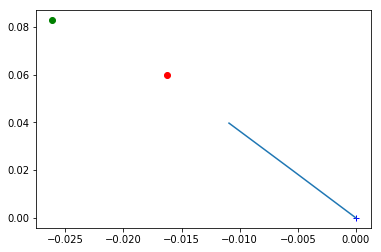

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -1.2867  0.0847
 -1.5468  0.2335
[torch.DoubleTensor of size 3x2]

[[-0.01426296  0.00232471]
 [-0.01825081  0.00506211]]


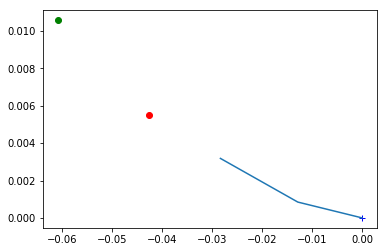

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  2.3135  0.9450
  2.1814  0.9357
[torch.DoubleTensor of size 3x2]

[[ 0.02092204  0.00894583]
 [ 0.01638349  0.00996585]]


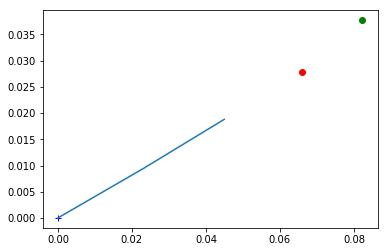

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


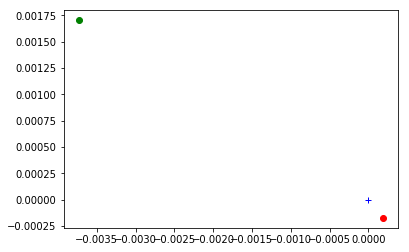

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


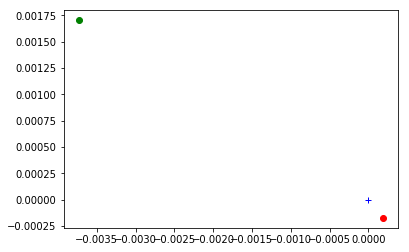

Variable containing:
-0.4491 -0.2360
-0.0207 -0.0109
-0.0241 -0.0127
[torch.DoubleTensor of size 3x2]

[[-0.03189799  0.00890789]
 [-0.03760979  0.01827253]]


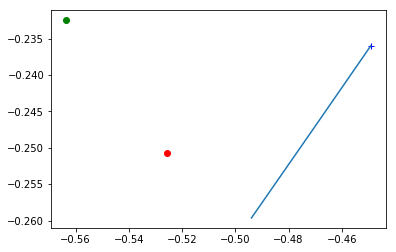

Variable containing:
1.00000e-02 *
  2.5587  1.9036
  2.5587  1.9036
  2.5587  1.9036
[torch.DoubleTensor of size 3x2]

[[ 0.02469452  0.01749115]
 [ 0.0199481   0.01801323]]


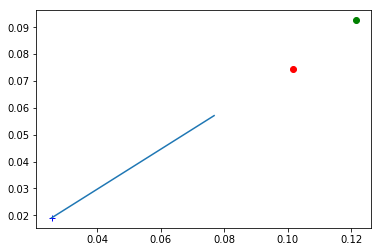

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


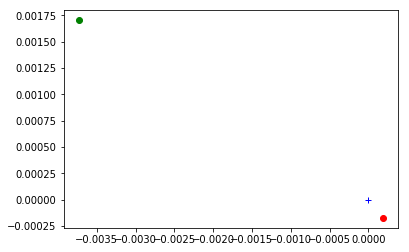

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


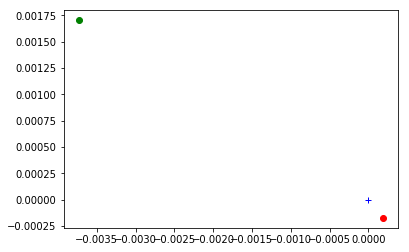

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


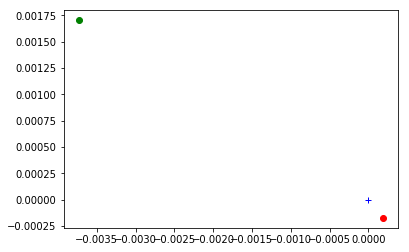

Variable containing:
1.00000e-02 *
 -2.9568 -2.4158
 -2.9568 -2.4158
 -2.9568 -2.4158
[torch.DoubleTensor of size 3x2]

[[-0.02820237 -0.02296931]
 [-0.03154854 -0.01921684]]


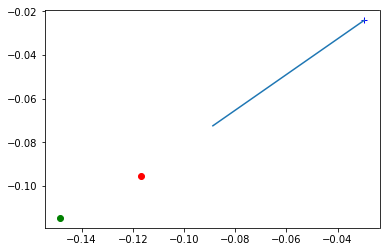

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


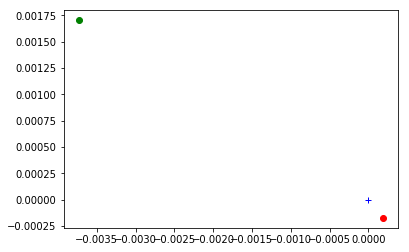

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  3.4410  2.6367
  1.5650  1.1993
[torch.DoubleTensor of size 3x2]

[[ 0.01791876  0.01322944]
 [ 0.01328451  0.01414725]]


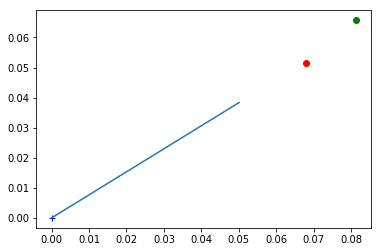

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -2.5431  2.0737
 -2.7576  2.2359
[torch.DoubleTensor of size 3x2]

[[-0.02610776  0.02310618]
 [-0.03046893  0.02652753]]


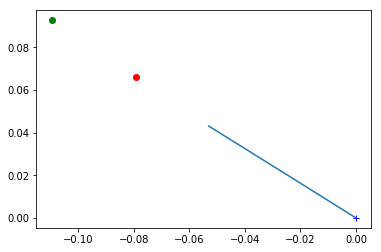

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  2.5808 -0.3433
  2.6948 -0.3616
[torch.DoubleTensor of size 3x2]

[[ 0.02573853 -0.00442021]
 [ 0.02146908 -0.00363802]]


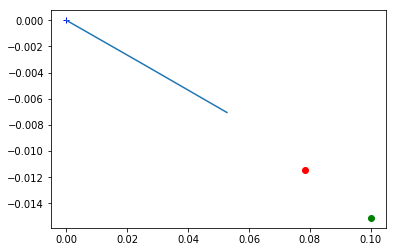

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  1.6288 -1.5403
  1.6153 -1.7282
[torch.DoubleTensor of size 3x2]

[[ 0.01594706 -0.01799481]
 [ 0.01210078 -0.01677563]]


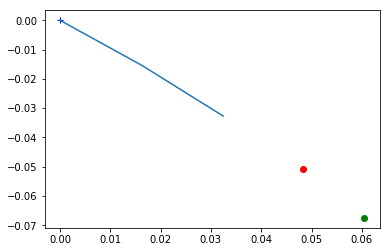

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -3.1342  1.1783
 -3.1359  1.1726
[torch.DoubleTensor of size 3x2]

[[-0.02974564  0.01243615]
 [-0.03385498  0.01601659]]


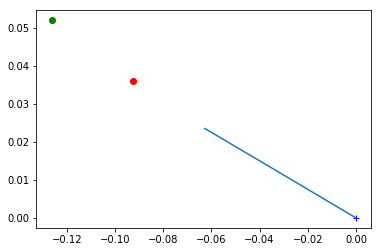

Variable containing:
1.00000e-02 *
 -4.5757  3.7032
 -4.5757  3.7032
 -4.5757  3.7032
[torch.DoubleTensor of size 3x2]

[[-0.04548107  0.040657  ]
 [-0.0509601   0.04567307]]


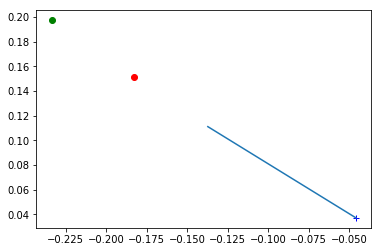

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  2.4920 -1.4752
  2.4322 -1.4390
[torch.DoubleTensor of size 3x2]

[[ 0.02363718 -0.01545048]
 [ 0.01968862 -0.01461282]]


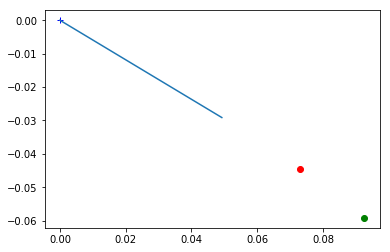

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


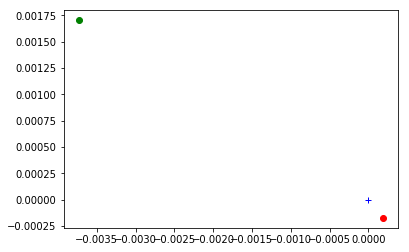

Variable containing:
1.00000e-02 *
  7.5865  5.8117
  1.5912  1.2287
  1.4510  1.1124
[torch.DoubleTensor of size 3x2]

[[ 0.01569892  0.00725495]
 [ 0.01141803  0.0075016 ]]


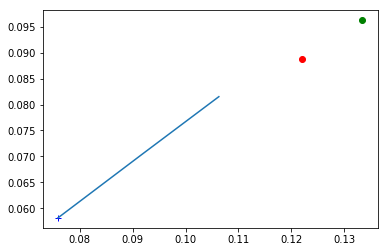

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


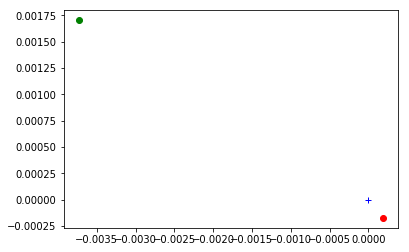

Variable containing:
1.00000e-02 *
 -2.6915  2.1740
 -2.6915  2.1740
 -2.6915  2.1740
[torch.DoubleTensor of size 3x2]

[[-0.02670508  0.02378268]
 [-0.03163868  0.02756829]]


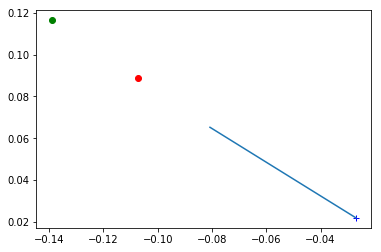

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


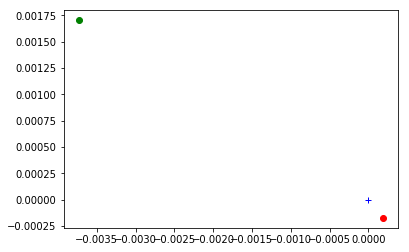

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


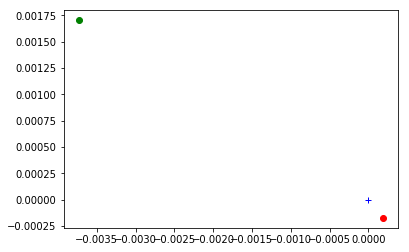

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -2.3890 -0.1190
 -1.9954 -0.1038
[torch.DoubleTensor of size 3x2]

[[-0.01927273 -0.00086584]
 [-0.02320838  0.00220144]]


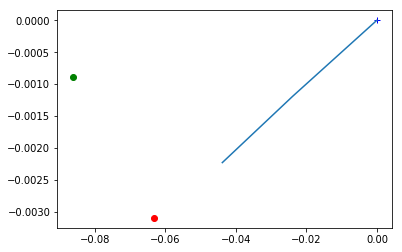

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


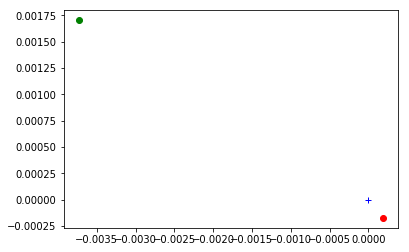

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -0.5013  2.0325
 -0.5115  2.1250
[torch.DoubleTensor of size 3x2]

[[-0.0050516   0.02162801]
 [-0.00963292  0.02402039]]


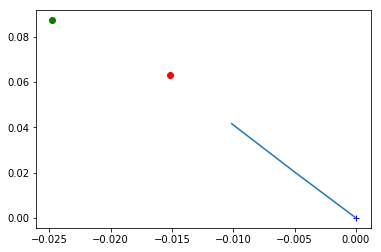

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


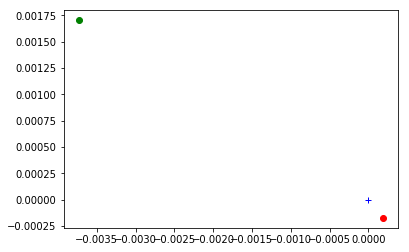

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  1.0063 -1.0671
  1.8350 -1.9356
[torch.DoubleTensor of size 3x2]

[[ 0.01729655 -0.01937436]
 [ 0.01331265 -0.01810012]]


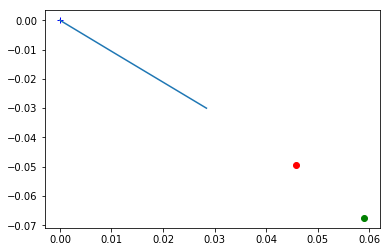

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


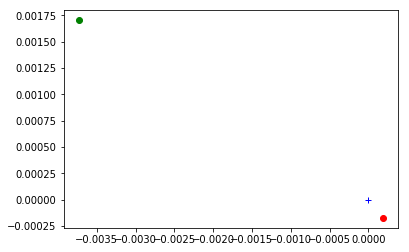

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  1.2741 -1.6220
  1.2641 -1.6068
[torch.DoubleTensor of size 3x2]

[[ 0.01248582 -0.01690134]
 [ 0.00866901 -0.01550749]]


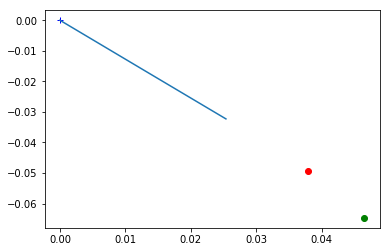

Variable containing:
 0.0813  0.1703
 0.0813  0.1703
 0.0813  0.1703
[torch.DoubleTensor of size 3x2]

[[ 0.07302015  0.16655108]
 [ 0.06231095  0.16359709]]


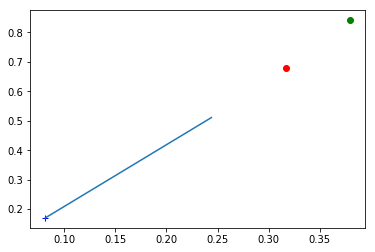

Variable containing:
-0.1962 -0.2957
-0.1962 -0.2957
-0.1962 -0.2957
[torch.DoubleTensor of size 3x2]

[[-0.18972318 -0.29060732]
 [-0.18578868 -0.27823448]]


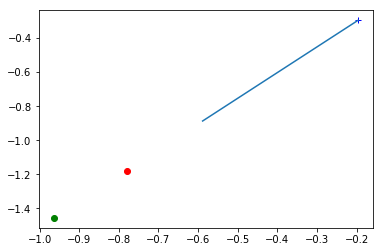

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -1.9926  2.6209
 -1.2753  1.6873
[torch.DoubleTensor of size 3x2]

[[-0.01272928  0.01848164]
 [-0.01734119  0.02135142]]


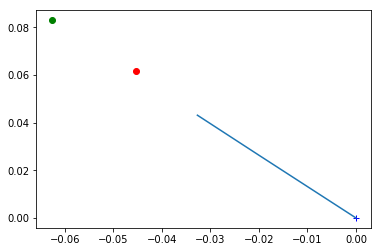

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  0.0973 -1.8481
  0.0611 -1.2907
[torch.DoubleTensor of size 3x2]

[[ 0.00077398 -0.01402481]
 [-0.00293539 -0.01204923]]


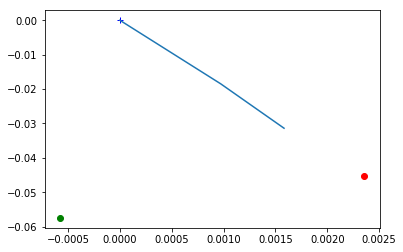

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


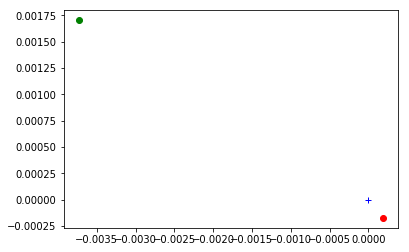

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


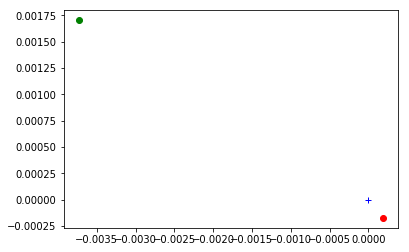

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -8.4079  0.7914
 -8.5985 -0.9450
[torch.DoubleTensor of size 3x2]

[[-0.0078634  -0.0007932 ]
 [-0.01190119  0.00165221]]


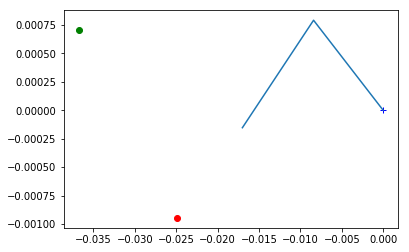

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -2.9547  0.2060
 -2.7440  0.2063
[torch.DoubleTensor of size 3x2]

[[-0.02617759  0.0024457 ]
 [-0.03010764  0.00583663]]


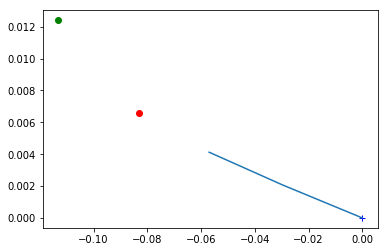

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  4.0614  0.7707
  1.2493  0.2380
[torch.DoubleTensor of size 3x2]

[[ 0.01590708  0.00239291]
 [ 0.01176198  0.00324388]]


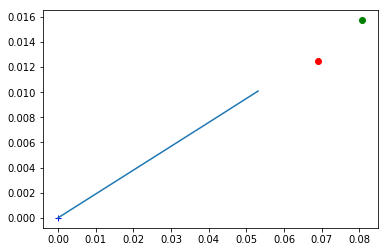

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


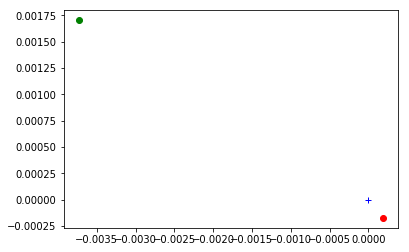

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


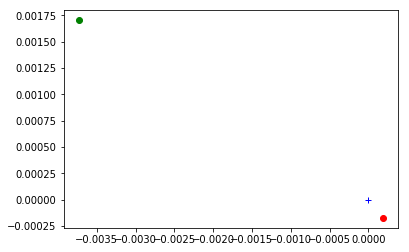

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


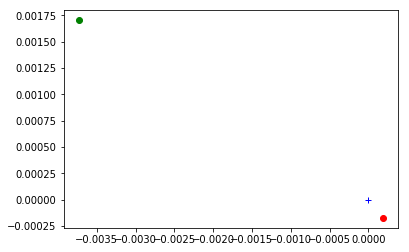

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -1.2025  1.4043
 -2.2561  2.9297
[torch.DoubleTensor of size 3x2]

[[-0.00193054  0.00269942]
 [-0.00606423  0.00485236]]


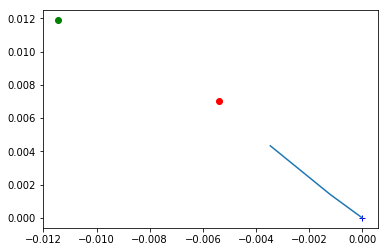

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -4.4759 -3.4449
 -4.8501 -3.2858
[torch.DoubleTensor of size 3x2]

[[-0.00432456 -0.00347244]
 [-0.00830741 -0.00121314]]


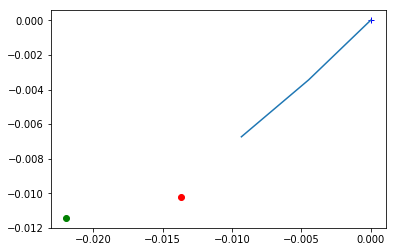

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


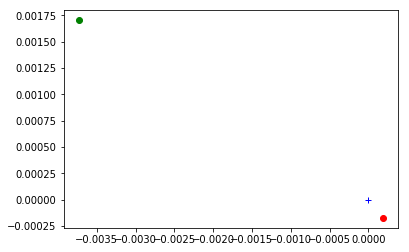

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


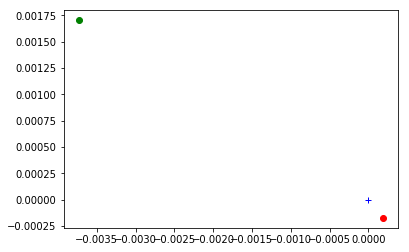

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


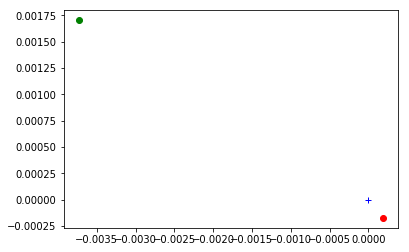

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


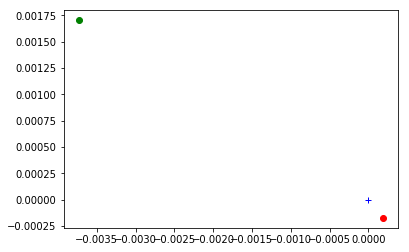

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -8.3996 -2.4293
 -7.8764 -2.8312
[torch.DoubleTensor of size 3x2]

[[-0.00730026 -0.00288264]
 [-0.01128307 -0.00046145]]


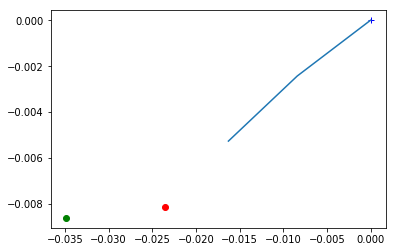

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


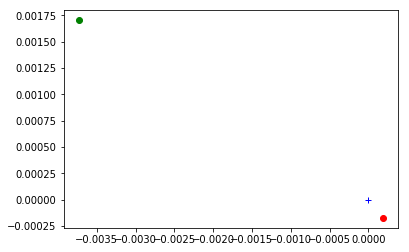

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


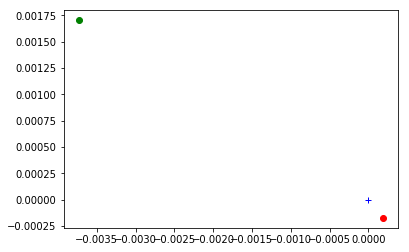

Variable containing:
1.00000e-02 *
  0.0000  0.0000
  1.1365  0.3708
  0.8808  0.2701
[torch.DoubleTensor of size 3x2]

[[ 0.00889194  0.00250797]
 [ 0.00463697  0.00409751]]


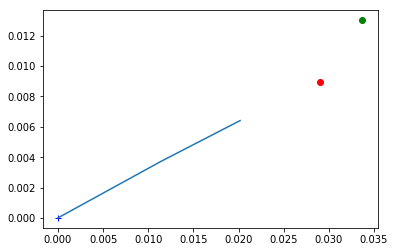

Variable containing:
1.00000e-03 *
  0.0000  0.0000
  6.6121 -0.9776
  7.0118 -0.8449
[torch.DoubleTensor of size 3x2]

[[ 0.00681126 -0.00119177]
 [ 0.00265632  0.00053521]]


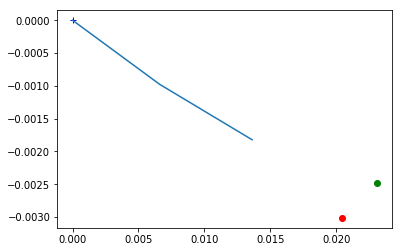

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


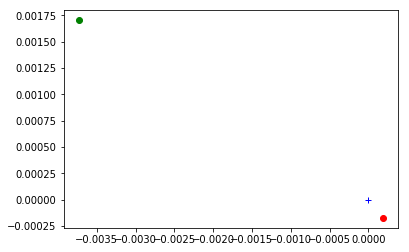

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


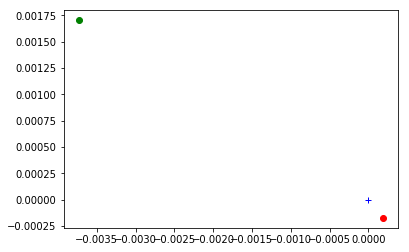

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


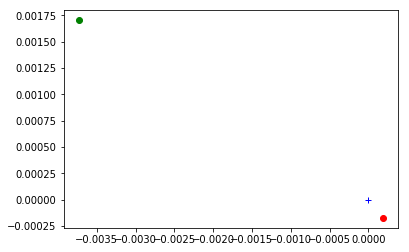

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


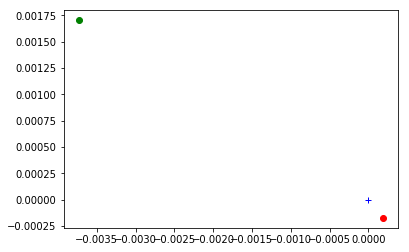

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


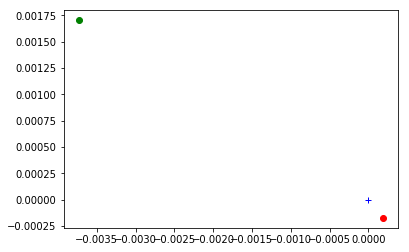

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


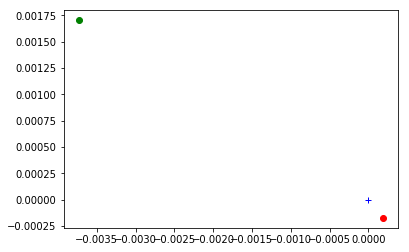

Variable containing:
1.00000e-03 *
  0.0000  0.0000
  8.1417 -4.9896
  5.5913 -3.2501
[torch.DoubleTensor of size 3x2]

[[ 0.00581312 -0.00382398]
 [ 0.00177881 -0.00209933]]


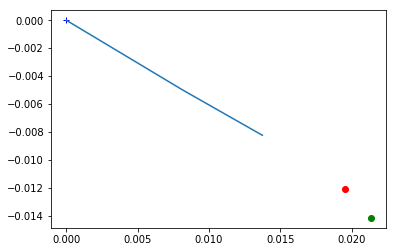

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -1.5077 -4.2937
 -0.7847 -1.8311
[torch.DoubleTensor of size 3x2]

[[-0.0007285  -0.00230051]
 [-0.00475628 -0.00019731]]


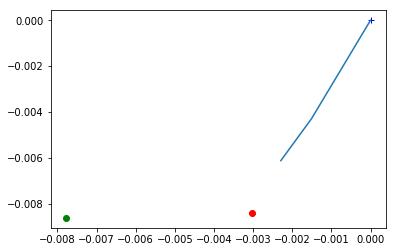

Variable containing:
1.00000e-03 *
  0.0000  0.0000
  0.1017 -8.7053
  0.2071 -9.6371
[torch.DoubleTensor of size 3x2]

[[ 0.00056922 -0.00995709]
 [-0.00332134 -0.00795374]]


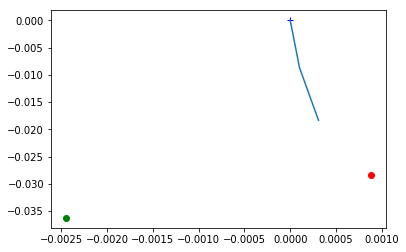

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -2.5431 -4.5156
 -2.7466 -4.3294
[torch.DoubleTensor of size 3x2]

[[-0.00233217 -0.00458359]
 [-0.00630869 -0.00242377]]


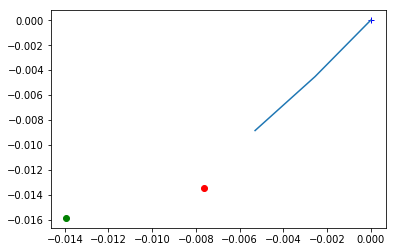

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -2.3106  3.5007
 -2.7756  3.2028
[torch.DoubleTensor of size 3x2]

[[-0.00242486  0.00319376]
 [-0.00659332  0.00538116]]


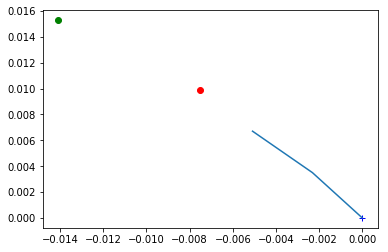

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


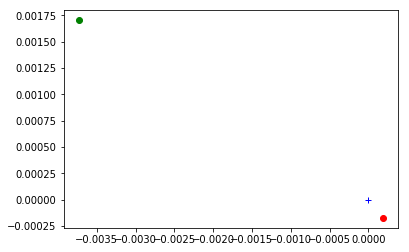

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


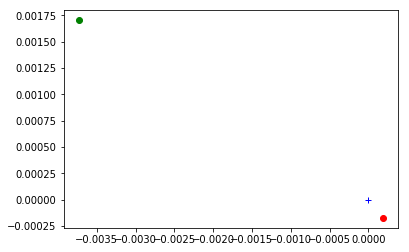

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


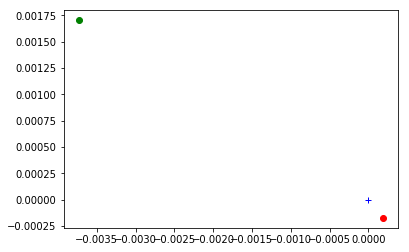

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


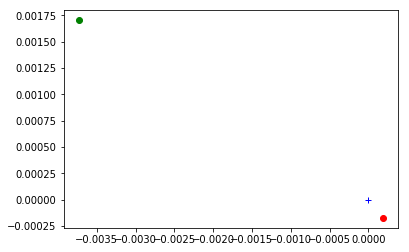

Variable containing:
1.00000e-02 *
 -1.4954 -9.4070
 -1.4954 -9.4070
 -1.4954 -9.4070
[torch.DoubleTensor of size 3x2]

[[-0.01234252 -0.09499086]
 [-0.01324343 -0.09226216]]


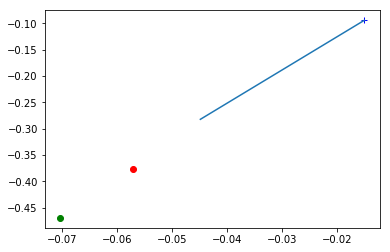

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


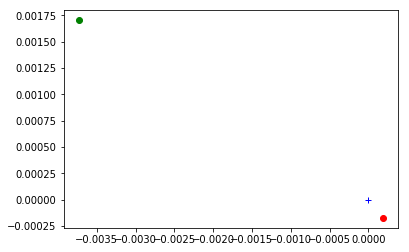

Variable containing:
1.00000e-02 *
  0.0000  0.0000
 -1.0720 -0.1480
 -1.2756 -0.1511
[torch.DoubleTensor of size 3x2]

[[-0.01163873 -0.00149994]
 [-0.01558496  0.00110126]]


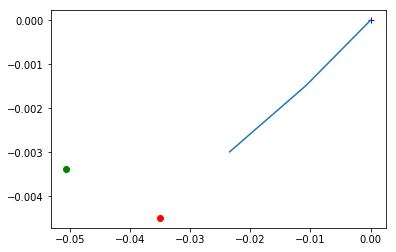

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


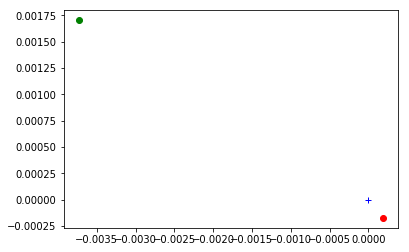

Variable containing:
1.00000e-03 *
  0.0000  0.0000
 -6.7749 -0.7782
 -6.0425 -0.8698
[torch.DoubleTensor of size 3x2]

[[-0.00562872 -0.00093611]
 [-0.00967296  0.00141312]]


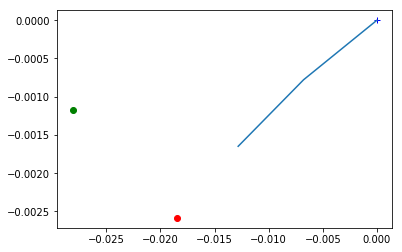

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


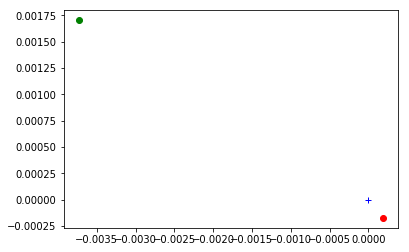

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


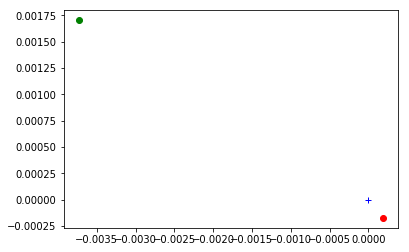

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


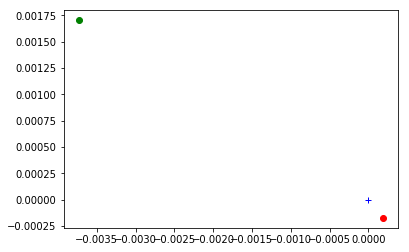

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


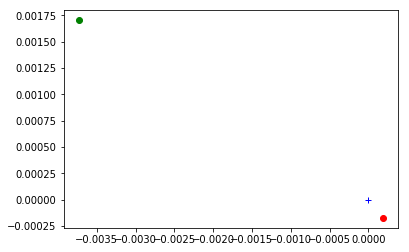

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


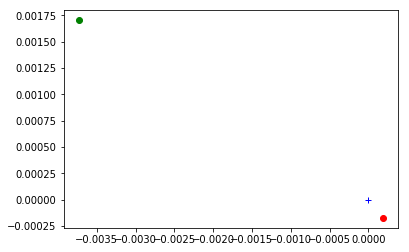

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


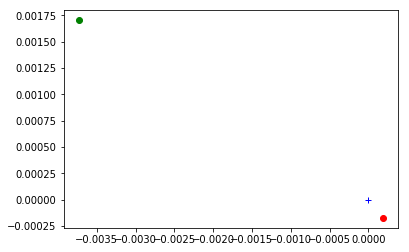

Variable containing:
1.00000e-02 *
 -1.3639 -1.6139
 -1.3639 -1.6139
 -1.3639 -1.6139
[torch.DoubleTensor of size 3x2]

[[-0.01276571 -0.01576294]
 [-0.0163437  -0.01293461]]


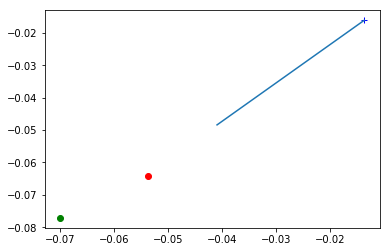

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


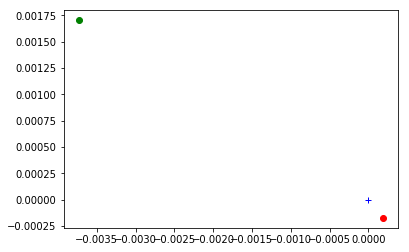

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


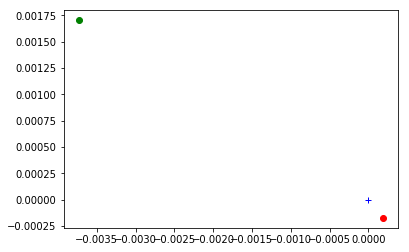

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


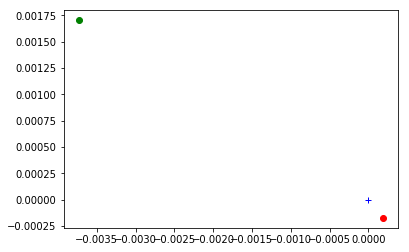

Variable containing:
1.00000e-03 *
  0.0000  0.0000
  5.3101  3.8173
  4.9014  3.1780
[torch.DoubleTensor of size 3x2]

[[ 0.00487618  0.0030531 ]
 [ 0.00063327  0.00487739]]


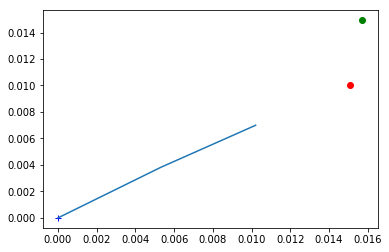

Variable containing:
 0  0
 0  0
 0  0
[torch.DoubleTensor of size 3x2]

[[ 0.00019077 -0.00017434]
 [-0.00392194  0.00187877]]


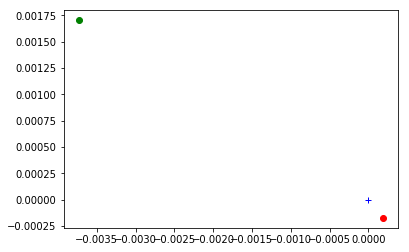

In [142]:
test_pred = seq(test_input,future).data.squeeze(1).numpy()
test_pred_latlon = test_pred[:, :, -2:]
# print(test_pred.shape)
for i in range(test_input.size(0)):
    latlon = test_input[i].data.numpy()[:, -2:]
    latlon = np.insert(latlon, latlon.shape[0], test_pred_latlon[i], axis=0)
    path = latlon.cumsum(axis=0)
    print(test_input[i])
    print(test_pred[i])
    pathx, pathy = np.split(path, 2, axis=1)
    plt.plot(pathx[0], pathy[0], 'b+')
    plt.plot(pathx[:-future], pathy[:-future])
    
    plt.plot(pathx[-2], pathy[-2], 'ro')
    plt.plot(pathx[-1], pathy[-1], 'go')
    plt.show()

In [ ]:
h_t = Variable(torch.zeros(1, 5).float(), requires_grad=False)
c_t = Variable(torch.zeros(1, 5).float(), requires_grad=False)
cell = nn.LSTMCell(5, 5)

ip = Variable(torch.from_numpy(np.array([0., 1., 2., 3., 4.])).float(), requires_grad=False)
print(cell(ip.unsqueeze(0), (h_t, c_t)))
ip = Variable(torch.from_numpy(np.array([1., 1., 2., 3., 4.])).float(), requires_grad=False)
print(cell(ip.unsqueeze(0), (h_t, c_t)))